In [1]:
import sys
sys.path
sys.path.insert(1, 'C:\\Users\\scj14\\BYU\\research\\image_encoder\\github\\experiment1\\')

from src.process_data import save_maps, load_maps, index2sentence, sentence2index, subsequent_mask
from src.encoderdecoder import EncoderDecoder, save_model, load_model
from src.dataset import TranslationDataset, AutoencoderDataset, padding_collate_fn, Batch
from src.image import tensor2image
from src.loss import ComputeLoss, LabelSmoothing

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import os


PAD = 0
SOS = 1
EOS = 2
UNK = 3

In [2]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
base_dir = "../text_corpora/prepared/"
data_dir = "eng/"
test_data = "books_test.txt"
map_dir = '../outputs/maps/'
model_dir = '../outputs/models/books_small/'
train_name = "books_train_small_txt-2023-02-16-01-53"

In [4]:
file_path = base_dir + data_dir + test_data
test_set = AutoencoderDataset(file_path, min_freq_vocab=0)
word2index, index2word = load_maps(train_name, map_dir=map_dir)
test_set.init_using_existing_maps(None, word2index, index2word)
vocab_size = len(test_set.word2index)
test_loader = DataLoader(
    test_set, 
    batch_size=100, 
    pin_memory=True, 
    collate_fn=padding_collate_fn, 
    shuffle=False
)
model = load_model(train_name + "-cp_{}".format(9), model_dir=model_dir)

Converting lines to indices...


# Test set

In [25]:
criterion = LabelSmoothing(size=vocab_size, padding_idx=0, smoothing=0.1)

In [26]:
def run_instance(batch, model, index2word, name, i):
    greedy_decoded, image_tensor = model.greedy_decode(batch.src[0], batch.src_pad_mask[0])
    beam_decoded, _ = model.beam_search(batch.src[0], batch.src_pad_mask[0])

    trg_len = (batch.trg_y[0]!=0).sum().item()
    
    log = open("../outputs/eval/{}/decoded_sentences.txt".format(name), 'a')
    log.write("Sentence number {}".format(i) + "\n")
    log.write("Input sentence: \n")
    log.write(index2sentence(batch.trg_y[0][:trg_len].tolist(), index2word))
    log.write("\n\n")
    log.write("Greedy decode output: \n")
    log.write(index2sentence(greedy_decoded[1:].tolist(), index2word))
    log.write("\n\n")
    log.write("Beam search outputs: \n")
    for j in range(5):
        log.write(index2sentence(beam_decoded[j][0][0,1:].tolist(), index2word))
        log.write("\n")
    log.write("\n\n\n")
    log.close()
    
    image = tensor2image(image_tensor[0])
    fig = plt.figure()
    plt.imshow(image)
    plt.savefig("../outputs/eval/{}/image-{}.png".format(name, i))
    plt.close(fig)

In [ ]:
name = train_name + "-cp_{}".format(9) + "_test"
model.to(gpu)
model.eval()
history = []

if not os.path.exists('../outputs/eval/' + name):
    os.mkdir('../outputs/eval/' + name)

with torch.no_grad():
    for i, batch in enumerate(test_loader):

        output, image = model(
            batch.src, batch.trg,
            src_mask=batch.src_pad_mask,
            trg_mask = batch.trg_attn_mask
        )
        loss = ComputeLoss(output, batch.trg_y, batch.trg_ntokens, criterion)
        history.append(loss.item())
        
        run_instance(
            batch, 
            model,  
            index2word, 
            name, 
            i
        )

avg_loss = np.mean(history)

In [10]:
avg_loss

0.5477990061044693

# Validation loss

In [16]:
val_loss = [1.7300687855671322,
            1.431622912368131,
            1.2695039976683875,
            1.1038733511453582,
            0.9968089157390216,
            0.9239085411859883,
            0.8892505476399074,
            0.8717684116628435,
            0.7973478297510791,
            0.7709701638373118,
            0.7517647303286052,
            0.7298462561789959,
            0.6838300837765611,
            0.6438303417452271,
            0.6220793458263553,
            0.6049760261639243,
            0.5805714305726781,
            0.566276166735897,
            0.55872928504906,
            0.567110823733466]

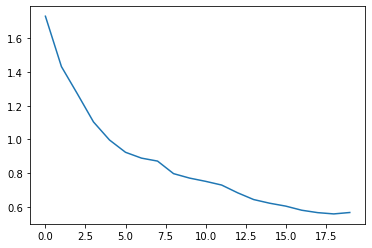

In [17]:
plt.plot(val_loss)

# Vector Interpolation

In [18]:
model.eval()
model.to("cpu")
def sentence2vector(model, s):
    zeros = 20 - len(s.split())
    t = torch.tensor([1] + sentence2index(s, word2index) + [0]*zeros).unsqueeze(0)
    mask = ((t != PAD) & (t != SOS)).unsqueeze(-2)
    with torch.no_grad():
        x = model.encode(t, mask)
    return x

In [19]:
s1 = "he stayed completely still for the next moment ."
s2 = "then she continued as calmly as she could ."

In [20]:
x1 = sentence2vector(model, s1)
x2 = sentence2vector(model, s2)

In [21]:
gd1, image1 = model.greedy_decode_from_vector(x1)
gd2, image2 = model.greedy_decode_from_vector(x2)

In [22]:
bd1, _ = model.beam_search_from_vector(x1)
bd2, _ = model.beam_search_from_vector(x2)

In [23]:
print(index2sentence(bd1[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd2[0][0][0,1:].tolist(), index2word))

he stayed completely still for the next moment . EOS
then she continued as calmly as she could . EOS


In [24]:
print(index2sentence(gd1[1:].tolist(), index2word))
print(index2sentence(gd2[1:].tolist(), index2word))

he stayed completely still for the next moment . EOS
then she continued as calmly as she could . EOS


he stayed completely still for the next moment . EOS


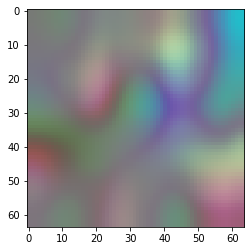

he stayed completely still for the next moment then . EOS


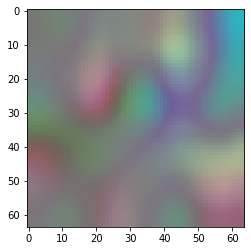

he stayed completely still for the next thought then . EOS


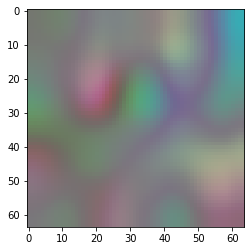

she stayed silent until suddenly i met his no one . EOS


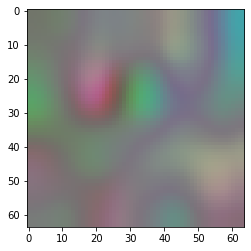

she stayed now as his eye never i waited . EOS


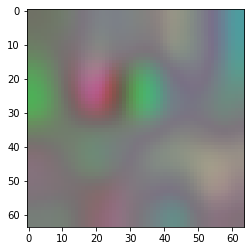

soon she stayed as he just stared when his voice . EOS


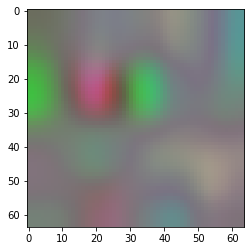

then she continued quietly as he could upon my emotions . EOS


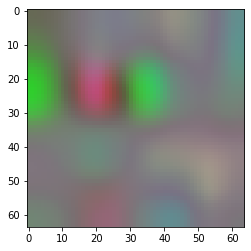

then she continued quietly as he could upon my battles . EOS


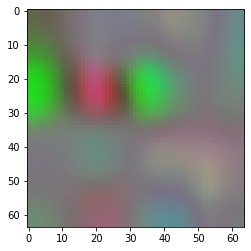

then she continued beth as fast as i could . EOS


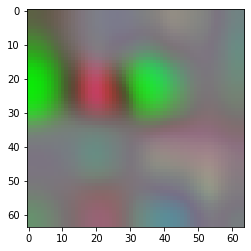

then she continued as calmly as he could . EOS


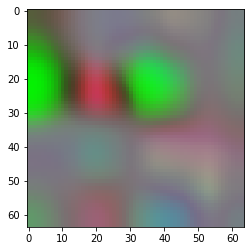

then she continued as calmly as she could . EOS


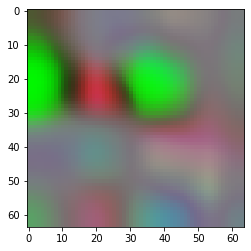

In [213]:
with torch.no_grad():
    for t in np.linspace(0, 1, 11):
        x = x1*(1-t) + x2*t
        decoded, image = model.beam_search_from_vector(x)
        print(index2sentence(decoded[0][0][0,1:].tolist(), index2word))
        plt.figure()
        plt.imshow(tensor2image(image[0]))
        plt.show()

# Gaussian Mixture Model Fitting

In [15]:
model.to(gpu)
model.eval()
latents = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x = model.encode(batch.src, src_mask=batch.src_pad_mask)
        latents.append(x.cpu().detach())

latents = torch.cat(latents).numpy()

In [16]:
latents.shape

(10000, 256)

In [17]:
from sklearn.mixture import GaussianMixture as GM

In [20]:
n_components = 20
gm = GM(n_components, verbose=2)
gm.fit(latents)

Initialization 0
  Iteration 10	 time lapse 12.82600s	 ll change 0.01728
  Iteration 20	 time lapse 11.52902s	 ll change 0.00255
  Iteration 30	 time lapse 11.44423s	 ll change 0.00879
Initialization converged: True	 time lapse 40.40644s	 ll 290.32563


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=20, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=2, verbose_interval=10, warm_start=False,
                weights_init=None)

In [24]:
model.to("cpu")
for i in range(n_components):
    samples = np.random.multivariate_normal(gm.means_[i], gm.covariances_[i], size=10)
    samples = torch.FloatTensor(samples)
    print("Component {}".format(i))
    for x in samples:
        decoded, _ = model.greedy_decode_from_vector(x.unsqueeze(0))
        print(index2sentence(decoded[1:].tolist(), index2word))
    print()

Component 0
i escaped if a jerk did promise . EOS
i m those she muttered , with answers or only arrested him . EOS
i do not write to us of their other clients . EOS
i never stopped there like got drugs , i m do why formal . EOS
i m not you know so shit and sit up her . EOS
i ve seen people leaving a frowning out much peaceful . EOS
i could fire so he it to why him though . EOS
you be onto i do to your life . EOS
i m like you , because i starts to pull me back to my test . EOS
i m wondering if knowing how much that s fun , he told me , not at least stop there . EOS

Component 1
on a bed after a man there and he knew things could go very far away . EOS
act pressed into a smirk he sensed no more of the faces she d missed but he tried to . EOS
i m so laid behind a few men in a seat and a good old order for dinner . EOS
there was a large human level pretty once again a part with others and caused the excitement to lines . EOS
a bloody hunter with each blow along in her heart , working a met

# Vector space operations

### subject pronoun manipulation

In [26]:
model.eval()
model.to("cpu")
s1_he = "he stayed completely still for the next moment ."
s1_she = "she stayed completely still for the next moment ."
s1_they = "they stayed completely still for the next moment ."
s1_i = "i stayed completely still for the next moment ."
s1_you = "you stayed completely still for the next moment ."
s1_we = "we stayed completely still for the next moment ."

In [30]:
x1_he = sentence2vector(model, s1_he)
x1_she = sentence2vector(model, s1_she)
x1_they = sentence2vector(model, s1_they)
x1_i = sentence2vector(model, s1_i)
x1_you = sentence2vector(model, s1_you)
x1_we = sentence2vector(model, s1_we)

In [31]:
_, img1_he = model.extract_features(x1_he)
_, img1_she = model.extract_features(x1_she)
_, img1_they = model.extract_features(x1_they)
_, img1_i = model.extract_features(x1_i)
_, img1_you = model.extract_features(x1_you)
_, img1_we = model.extract_features(x1_we)

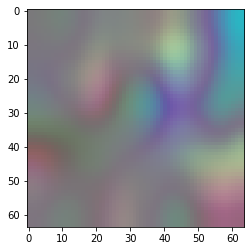

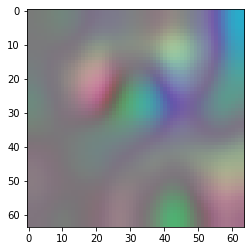

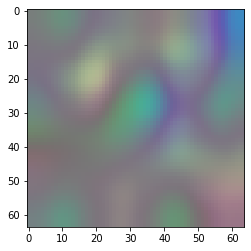

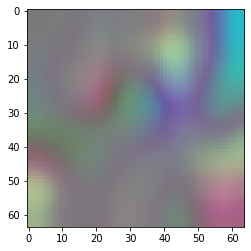

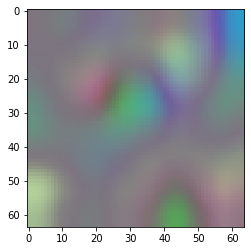

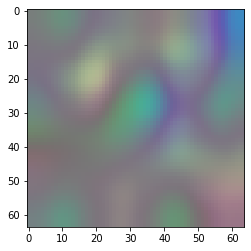

In [32]:
plt.figure()
plt.imshow(tensor2image(img1_he[0]))
plt.show()
plt.imshow(tensor2image(img1_she[0]))
plt.show()
plt.imshow(tensor2image(img1_they[0]))
plt.show()
plt.imshow(tensor2image(img1_i[0]))
plt.show()
plt.imshow(tensor2image(img1_you[0]))
plt.show()
plt.imshow(tensor2image(img1_they[0]))
plt.show()

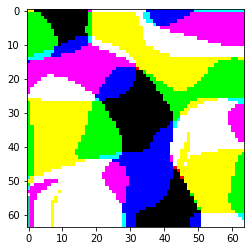

In [41]:
with torch.no_grad():
    z = x1_we - x1_i
    _, img_z = model.extract_features(z)
plt.imshow(tensor2image(img_z[0]))
plt.show()

they stayed completely still for the next moment . EOS


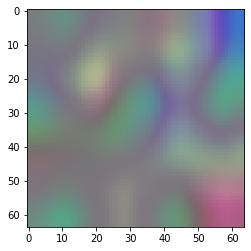

In [35]:
with torch.no_grad():
    z = x1_we - x1_i + x1_he
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

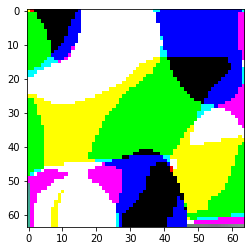

In [38]:
with torch.no_grad():
    z = x1_they - x1_he
    _, img_z = model.extract_features(z)
plt.imshow(tensor2image(img_z[0]))
plt.show()

completely we stayed still for the next moment . EOS


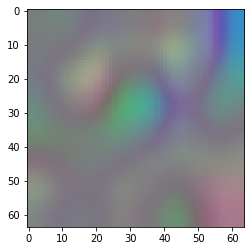

In [36]:
with torch.no_grad():
    z = x1_they - x1_he + x1_i
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

you stayed completely still for their next time . EOS


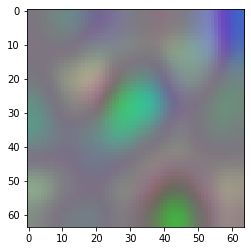

In [39]:
with torch.no_grad():
    z = x1_they - x1_he + x1_you
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

you stayed completely still for our moment they next . EOS


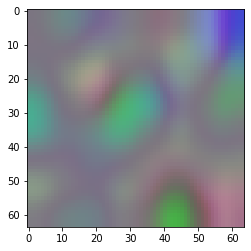

In [40]:
with torch.no_grad():
    z = x1_we - x1_i + x1_you
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

then he continued as calmly as he could . EOS


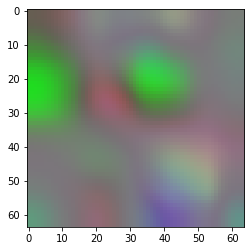

In [43]:
s2_he = "then he continued as calmly as he could ."
x2_he = sentence2vector(model, s2_he)
_, img_x2_he = model.extract_features(x2_he)
bd_x2_he, _ = model.beam_search_from_vector(x2_he)
print(index2sentence(bd_x2_he[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_x2_he[0]))
plt.show()

then they continued as calmly as he could . EOS


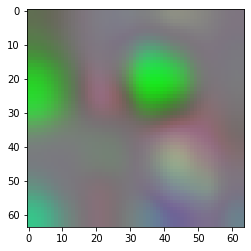

In [44]:
with torch.no_grad():
    z = x1_they - x1_he + x2_he
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

then she continued as calmly as he could . EOS


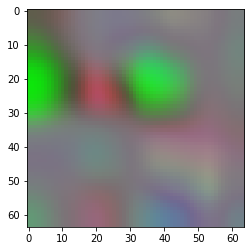

In [45]:
with torch.no_grad():
    z = x1_she - x1_he + x2_he
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

### tense manipulation

In [73]:
s3_1 = "i am there ."
s3_2 = "i will be there ."
s3_3 = "i was there ."

In [74]:
x3_1 = sentence2vector(model, s3_1)
x3_2 = sentence2vector(model, s3_2)
x3_3 = sentence2vector(model, s3_3)
bd_x3_1, _ = model.beam_search_from_vector(x3_1)
bd_x3_2, _ = model.beam_search_from_vector(x3_2)
bd_x3_3, _ = model.beam_search_from_vector(x3_3)
print(index2sentence(bd_x3_1[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd_x3_2[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd_x3_3[0][0][0,1:].tolist(), index2word))

i am there . EOS
i will be there . EOS
i was there . EOS


In [98]:
s4 = "i am going with you ."

In [99]:
x4 = sentence2vector(model, s4)
bd_x4, _ = model.beam_search_from_vector(x4)
print(index2sentence(bd_x4[0][0][0,1:].tolist(), index2word))

i am going with you . EOS


i will be going with you . EOS


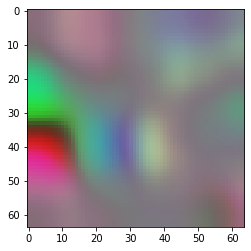

In [71]:
with torch.no_grad():
    z = x3_2 - x3_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i was going with you . EOS


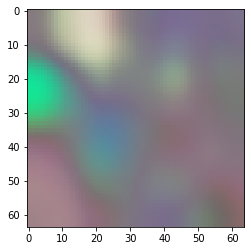

In [75]:
with torch.no_grad():
    z = x3_3 - x3_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

#### tense + pronoun

they are going with you . EOS


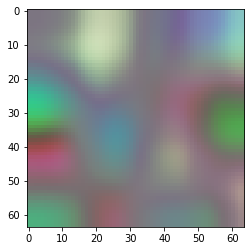

In [77]:
with torch.no_grad():
    z = x1_they - x1_i + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

they will be going with you . EOS


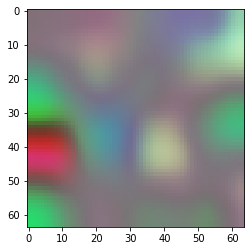

In [78]:
with torch.no_grad():
    z = x1_they - x1_i + x3_2 - x3_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

they was going with you . EOS


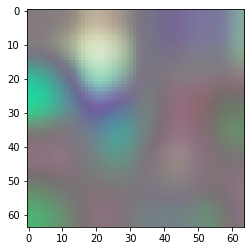

In [79]:
with torch.no_grad():
    z = x1_they - x1_i + x3_3 - x3_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

In [84]:
s5_1 = "i run in the morning ."
s5_2 = "i ran in the morning ."
x5_1 = sentence2vector(model, s5_1)
x5_2 = sentence2vector(model, s5_2)
bd_x5_1, _ = model.beam_search_from_vector(x5_1)
print(index2sentence(bd_x5_1[0][0][0,1:].tolist(), index2word))
bd_x5_2, _ = model.beam_search_from_vector(x5_2)
print(index2sentence(bd_x5_2[0][0][0,1:].tolist(), index2word))

i run in the morning . EOS
i ran in the morning . EOS


i ll run in the morning being . EOS


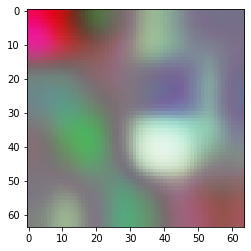

In [83]:
with torch.no_grad():
    z = x3_2 - x3_1 + x5_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i were there . EOS


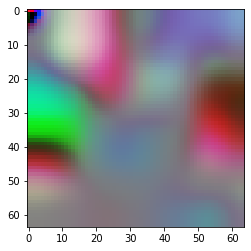

In [103]:
with torch.no_grad():
    z = x5_2 - x5_1 + x3_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

### negation

In [89]:
s3_not = "i am not there ."
x3_not = sentence2vector(model, s3_not)
bd_x3_not, _ = model.beam_search_from_vector(x3_not)
print(index2sentence(bd_x3_not[0][0][0,1:].tolist(), index2word))

i am not there . EOS


i will not be there . EOS


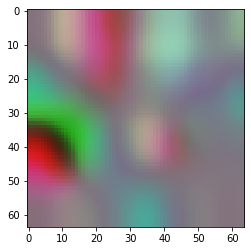

In [92]:
with torch.no_grad():
    z = x3_not - x3_1 + x3_2
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i was not there . EOS


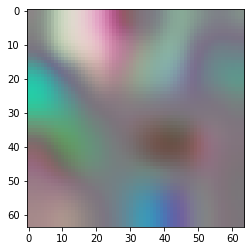

In [93]:
with torch.no_grad():
    z = x3_not - x3_1 + x3_3
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i run not in the morning . EOS


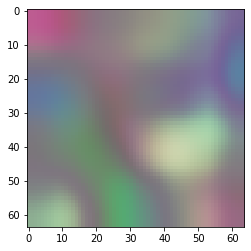

In [96]:
with torch.no_grad():
    z = x3_not - x3_1 + x5_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i am not going with you . EOS


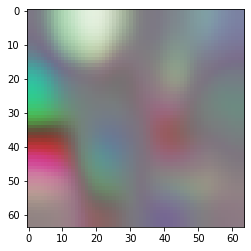

In [100]:
with torch.no_grad():
    z = x3_not - x3_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

### statement to question

In [105]:
s6_1 = "you can go home ."
s6_2 = "can you go home ?"
x6_1 = sentence2vector(model, s6_1)
x6_2 = sentence2vector(model, s6_2)
bd_x6_1, _ = model.beam_search_from_vector(x6_1)
bd_x6_2, _ = model.beam_search_from_vector(x6_2)
print(index2sentence(bd_x6_1[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd_x6_2[0][0][0,1:].tolist(), index2word))

you can go home . EOS
can you go home ? EOS


am i going with you ? EOS


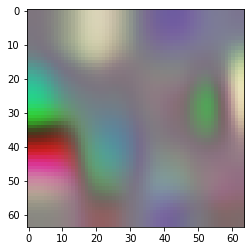

In [107]:
with torch.no_grad():
    z = x6_2 - x6_1 + x4
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

am i there ? EOS


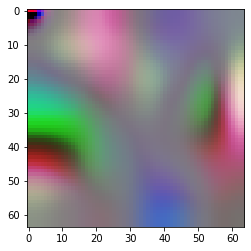

In [108]:
with torch.no_grad():
    z = x6_2 - x6_1 + x3_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

will i be there ? EOS


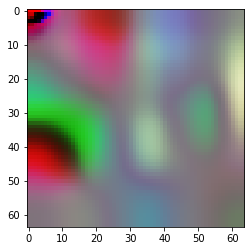

In [109]:
with torch.no_grad():
    z = x6_2 - x6_1 + x3_2
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

i was there ? EOS


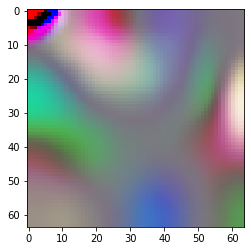

In [110]:
with torch.no_grad():
    z = x6_2 - x6_1 + x3_3
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

### commanding vs requesting

In [141]:
s7_1 = "clean your room ."
s7_2 = "can you clean your room ?"
x7_1 = sentence2vector(model, s7_1)
x7_2 = sentence2vector(model, s7_2)
bd_x7_1, _ = model.beam_search_from_vector(x7_1)
bd_x7_2, _ = model.beam_search_from_vector(x7_2)
print(index2sentence(bd_x7_1[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd_x7_2[0][0][0,1:].tolist(), index2word))

clean your room . EOS
can you clean your room ? EOS


In [144]:
s8_1 = "come to my house ."
s8_2 = "can you come to my house ?"
x8_1 = sentence2vector(model, s8_1)
x8_2 = sentence2vector(model, s8_2)
bd_x8_1, _ = model.beam_search_from_vector(x8_1)
bd_x8_2, _ = model.beam_search_from_vector(x8_2)
print(index2sentence(bd_x8_1[0][0][0,1:].tolist(), index2word))
print(index2sentence(bd_x8_2[0][0][0,1:].tolist(), index2word))

come to my house . EOS
can you come to my house ? EOS


can you come to my house ? EOS


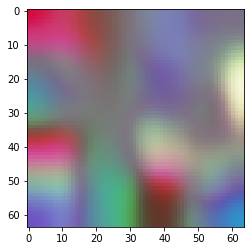

In [145]:
with torch.no_grad():
    z = x7_2 - x7_1 + x8_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

come to my house . EOS


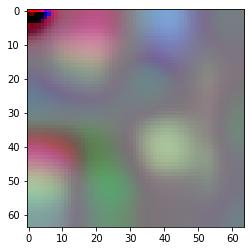

In [146]:
with torch.no_grad():
    z = x7_1 - x7_2 + x8_2
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

can you clean your room ? EOS


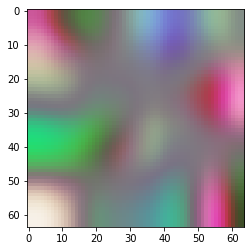

In [147]:
with torch.no_grad():
    z = x8_2 - x8_1 + x7_1
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()

clean your room . EOS


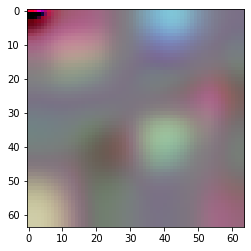

In [148]:
with torch.no_grad():
    z = x8_1 - x8_2 + x7_2
    _, img_z = model.extract_features(z)
bd_z, _ = model.beam_search_from_vector(z)
print(index2sentence(bd_z[0][0][0,1:].tolist(), index2word))
plt.imshow(tensor2image(img_z[0]))
plt.show()